In [66]:
import cv2
import tifffile as tiff
import os 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [149]:
def parse_voc_rec(filename):
    """
    parse pascal voc record into a dictionary
    :param filename: xml file path
    :return: list of dict
    """
    import xml.etree.ElementTree as ET
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_dict = dict()
        obj_dict['name'] = obj.find('name').text
        obj_dict['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_dict['bbox'] = [int(bbox.find('xmin').text),
                            int(bbox.find('ymin').text),
                            int(bbox.find('xmax').text),
                            int(bbox.find('ymax').text)]
        objects.append(obj_dict)
    return objects

In [121]:
vis_img_folder_name = '../mxnet-ssd/data/cvc/Night/Visible/test/FramesPos/'
fir_img_folder_name = '../mxnet-ssd/data/cvc/Night/FIR/test/FramesPos/'
annotation_foldet_name = '../mxnet-ssd/data/cvc/Night/Visible/test/Annotations/'

id_boxes = []
index_img = []

for i in os.listdir(vis_img_folder_name):
        
    # open annotations
    a = open(annotation_foldet_name+i[:-4]+'.txt', 'r')
    bboxs = a.read().splitlines()
    a.close()

    if len(bboxs) > 0:
        index_img.append(i[:-4])
        
        # open vis/fir image
        try:
            v_img = tiff.imread(vis_img_folder_name+i)[:,:, np.newaxis]
            f_img = tiff.imread(fir_img_folder_name+i) # three channel fir image
        except:
            print 'ошибка чтения файлов'
            continue

        # concatenate and save
        img = np.concatenate([v_img[:470, :640:, :], f_img[:470, :640:, :]], axis=2)
        np.save('../mxnet-ssd/data/cvc/images/'+i[:-4]+'.npy', img)
        
        # add basic annotations info     
        f = open('../mxnet-ssd/data/cvc/annotations/' + i[:-4]+'.xml','w')
        line = "<annotation>" + '\n'
        f.write(line)
        line = '\t\t<folder>' + "folder" + '</folder>' + '\n'
        f.write(line)
        line = '\t\t<filename>' + i[:-4] + '</filename>' + '\n'
        f.write(line)
        line = '\t\t<source>\n\t\t<database>Source</database>\n\t</source>\n'
        f.write(line)
        (width, height) = img.shape[0], img.shape[1]
        line = '\t<size>\n\t\t<width>'+ str(width) + '</width>\n\t\t<height>' + str(height) + '</height>\n\t'
        line += '\t<depth>4</depth>\n\t</size>'
        f.write(line)
        line = '\n\t<segmented>Unspecified</segmented>'
        f.write(line)
        
        for bbox in bboxs:
            data = [x for x in bbox.split(' ') if x != '']
            x = int(data[0])
            y = int(data[1])
            w = int(data[2])
            h = int(data[3])
            
            xmin = x-w/2
            ymin = y-h/2
            xmax = x+w/2
            ymax = y+h/2
            
            line = '\n\t<object>'
            line += '\n\t\t<name>person</name>\n\t\t<pose>Unspecified</pose>'
            line += '\n\t\t<truncated>Unspecified</truncated>\n\t\t<difficult>0</difficult>'
            line += '\n\t\t<bndbox>\n\t\t\t<xmin>' + str(xmin) + '</xmin>'            
            line += '\n\t\t\t<ymin>' + str(ymin) + '</ymin>'
            line += '\n\t\t\t<xmax>' + str(xmax) + '</xmax>'
            line += '\n\t\t\t<ymax>' + str(ymax) + '</ymax>'
            line += '\n\t\t</bndbox>'
            line += '\n\t</object>\n' 
            f.write(line) 

        line = "</annotation>" + '\n'
        f.write(line)
        f.close()
    
d = open('../mxnet-ssd/data/cvc/image_sets/test_night.txt', 'w')
for ind in index_img:
    d.write(ind+'\n')
d.close()

In [148]:
train_index_day = open('../mxnet-ssd/data/cvc/image_sets/train_day.txt').read().splitlines()
train_index_night = open('../mxnet-ssd/data/cvc/image_sets/train_night.txt').read().splitlines()
train_index = train_index_day+train_index_night

d = open('../mxnet-ssd/data/cvc/image_sets/train.txt', 'w')
for ind in train_index:
    d.write(ind+'\n')
d.close()

print 'train', len(train_index_day), len(train_index_night), len(train_index)

test_index_day = open('../mxnet-ssd/data/cvc/image_sets/test_day.txt').read().splitlines()
test_index_night = open('../mxnet-ssd/data/cvc/image_sets/test_night.txt').read().splitlines()
test_index = test_index_day+test_index_night

d = open('../mxnet-ssd/data/cvc/image_sets/test.txt', 'w')
for ind in test_index:
    d.write(ind+'\n')
d.close()

print 'test', len(test_index_day), len(test_index_night), len(test_index)

train 925 572 1497
test 664 656 1320


In [129]:
# mean calculations 
# calculate mean for training set
mean_pixel_vis = []
mean_pixel_f1 = []
mean_pixel_f2 = []
mean_pixel_f3 = []

for i, name in enumerate(os.listdir('../mxnet-ssd/data/cvc/images/')):
    if name[:-4] in train_index:
        image_rgb = np.load(('../mxnet-ssd/data/cvc/images/'+name))
        mean_pixel_vis.append(image_rgb[:,:,0].mean())
        mean_pixel_f1.append(image_rgb[:,:,1].mean())
        mean_pixel_f2.append(image_rgb[:,:,2].mean())
        mean_pixel_f3.append(image_rgb[:,:,3].mean())
        
# print pixel values
print 'vis: ', np.array(mean_pixel_vis).mean()
print 'f1: ', np.array(mean_pixel_f1).mean()
print 'f2: ', np.array(mean_pixel_f2).mean()
print 'f3: ', np.array(mean_pixel_f3).mean()


vis:  97.9502343483
f1:  142.597139797
f2:  142.597139797
f3:  142.597139797


In [142]:
# calculate std for training set
std_pixel_vis = 0
std_pixel_f1 = 0
std_pixel_f2 = 0
std_pixel_f3 = 0

for i, name in enumerate(os.listdir('../mxnet-ssd/data/cvc/images/')):
    if name[:-4] in train_index:
        image_rgb = np.load(('../mxnet-ssd/data/cvc/images/'+name))
        std_pixel_vis += (image_rgb[:,:,0] - 97.9502343483)**2
        std_pixel_f1 += (image_rgb[:,:,1] - 142.597139797)**2
        std_pixel_f2 += (image_rgb[:,:,2] - 142.597139797)**2
        std_pixel_f3 += (image_rgb[:,:,3] - 142.597139797)**2
        
# print std values
print 'vis: ', np.mean((std_pixel_vis/len(train_index))**0.5)
print 'f1: ', np.mean((std_pixel_f1/len(train_index))**0.5)
print 'f2: ', np.mean((std_pixel_f2/len(train_index))**0.5)
print 'f3: ', np.mean((std_pixel_f3/len(train_index))**0.5)

vis:  45.4091595303
f1:  55.7261941953
f2:  55.7261941953
f3:  55.7261941953


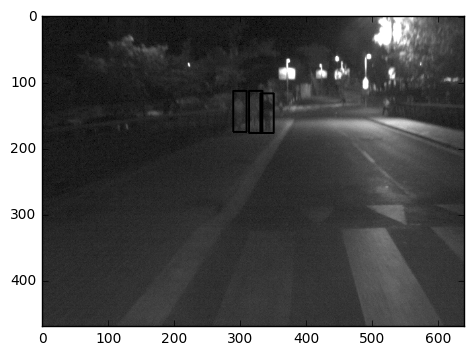

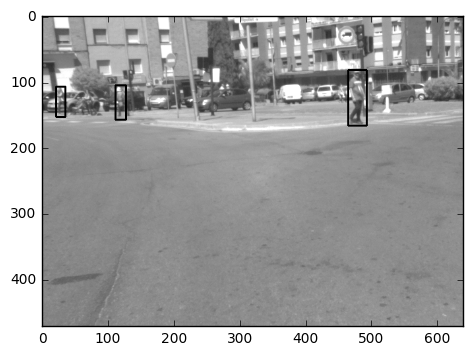

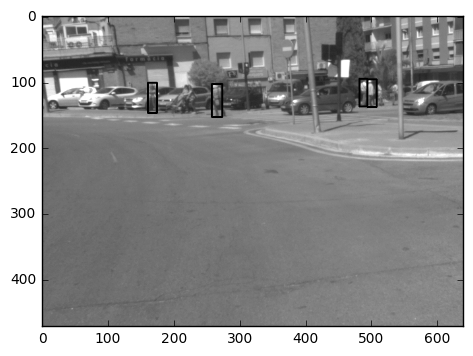

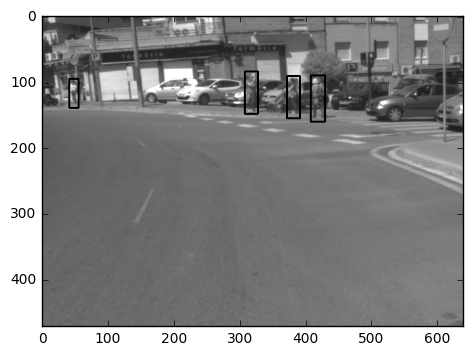

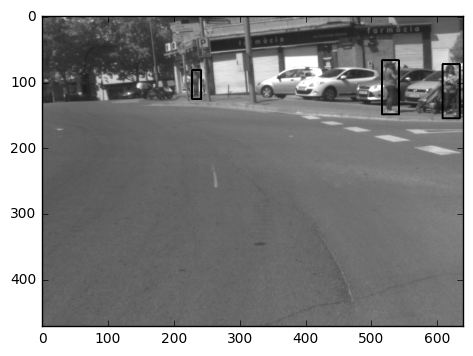

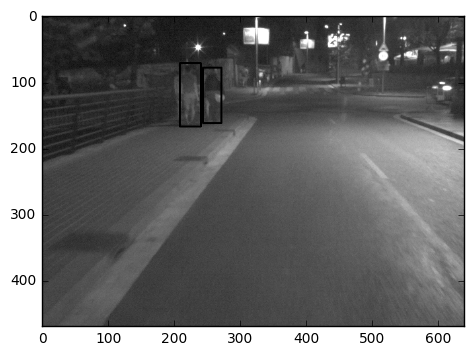

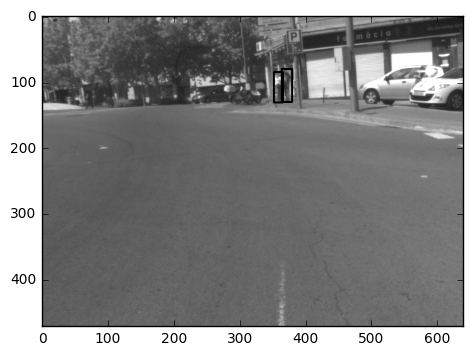

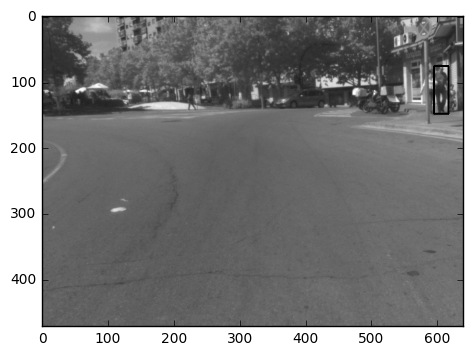

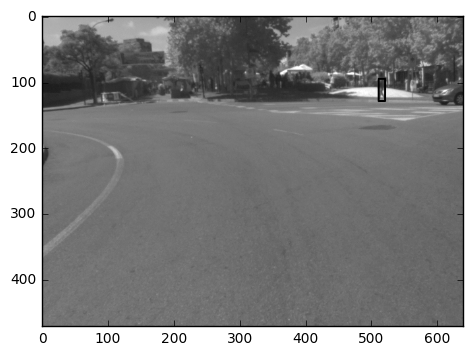

In [160]:
for i, name in enumerate(os.listdir('../mxnet-ssd/data/cvc/images/')[10:100:10]):
    annotations = parse_voc_rec('../mxnet-ssd/data/cvc/annotations/'+name[:-4]+'.xml')
    image_rgb = np.load(('../mxnet-ssd/data/cvc/images/'+name))
    image_vis = image_rgb[:,:,0].copy()
    for annotation in annotations:
        x = annotation['bbox'][0]
        y = annotation['bbox'][1]
        xmax = annotation['bbox'][2]
        ymax =annotation['bbox'][3]
        cv2.rectangle(image_vis,(x,y),(xmax,ymax),(0,255,0), 2)
    plt.imshow(image_vis, cmap='gray')
    plt.show()